In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [37]:
df1 = pd.read_csv('Scraping Data/Data_Lamudi_co_id.csv')
df2 = pd.read_csv('Scraping Data/data_properti_lamudi_page_26-35.csv')

columns = ['Kamar Tidur','Kamar Mandi', 'Luas Bangunan \n(m²)', 'Luas Tanah \n(m²)', 'Harga']

df1 = df1[columns]
df2 = df2[columns]

df1.head()

,Kamar Tidur,Kamar Mandi,Luas Bangunan \n(m²),Luas Tanah \n(m²),Harga
0,3.0,4.0,300.0,210.0,"Rp 2,30M"
1,4.0,4.0,110.0,78.0,"Rp 1,98M"
2,3.0,3.0,84.0,24.0,"Rp 1,70M"
3,3.0,1.0,90.0,135.0,"Rp 1,25M"
4,4.0,3.0,170.0,105.0,"Rp 4,50M"


In [169]:
df = pd.concat([df1, df2], axis=0)
# Rename kolom
df.rename(columns={
    "Luas Bangunan \n(m²)": "Luas Bangunan",
    "Luas Tanah \n(m²)": "Luas Tanah"
}, inplace=True)
df

,Kamar Tidur,Kamar Mandi,Luas Bangunan,Luas Tanah,Harga
0,3.0,4.0,300.0,210.0,"Rp 2,30M"
1,4.0,4.0,110.0,78.0,"Rp 1,98M"
2,3.0,3.0,84.0,24.0,"Rp 1,70M"
3,3.0,1.0,90.0,135.0,"Rp 1,25M"
4,4.0,3.0,170.0,105.0,"Rp 4,50M"
...,...,...,...,...,...
264,2.0,1.0,36.0,60.0,Rp 500Jt
265,10.0,6.0,505.0,629.0,Rp 60M
266,4.0,4.0,265.0,350.0,"Rp 11,90M"
267,2.0,1.0,30.0,60.0,Rp 185Jt


In [170]:
# 4. Cek jumlah missing value
print("Jumlah nilai kosong per kolom:")
print(df.isnull().sum())

# 5. Cek tipe data
print("\nTipe data:")
print(df.dtypes)

Jumlah nilai kosong per kolom:
Kamar Tidur      5
Kamar Mandi      5
Luas Bangunan    6
Luas Tanah       5
Harga            0
dtype: int64

Tipe data:
Kamar Tidur      float64
Kamar Mandi      float64
Luas Bangunan    float64
Luas Tanah       float64
Harga             object
dtype: object


In [171]:
# Menghapus semua baris yang memiliki nilai null di minimal satu kolom
df_clean = df.dropna()

# Reset index agar berurutan kembali
df_clean.reset_index(drop=True, inplace=True)

# Cek apakah masih ada nilai null
print(df_clean.isnull().sum())


Kamar Tidur      0
Kamar Mandi      0
Luas Bangunan    0
Luas Tanah       0
Harga            0
dtype: int64


In [172]:
def convert_harga(harga_str):
    try:
        # Normalisasi string
        harga_str = (
            harga_str.replace("Rp", "")
                     .replace(" ", "")
                     .replace(",", ".")
                     .upper()
        )
        
        if "M" in harga_str:
            angka = float(harga_str.replace("M", ""))
            return angka * 1_000_000_000  # 1 Miliar = 1.000.000.000
        elif "JT" in harga_str:
            angka = float(harga_str.replace("JT", ""))
            return angka * 1_000_000  # 1 Juta = 1.000.000
        else:
            # fallback jika tidak ada M atau JT
            return float(harga_str)
    except:
        return np.nan

df_clean.loc[:, "Harga"] = df_clean["Harga"].apply(convert_harga)

In [174]:
df_clean

,Kamar Tidur,Kamar Mandi,Luas Bangunan,Luas Tanah,Harga
0,3.0,4.0,300.0,210.0,2300000000.0
1,4.0,4.0,110.0,78.0,1980000000.0
2,3.0,3.0,84.0,24.0,1700000000.0
3,3.0,1.0,90.0,135.0,1250000000.0
4,4.0,3.0,170.0,105.0,4500000000.0
...,...,...,...,...,...
941,2.0,1.0,36.0,60.0,500000000.0
942,10.0,6.0,505.0,629.0,60000000000.0
943,4.0,4.0,265.0,350.0,11900000000.0
944,2.0,1.0,30.0,60.0,185000000.0


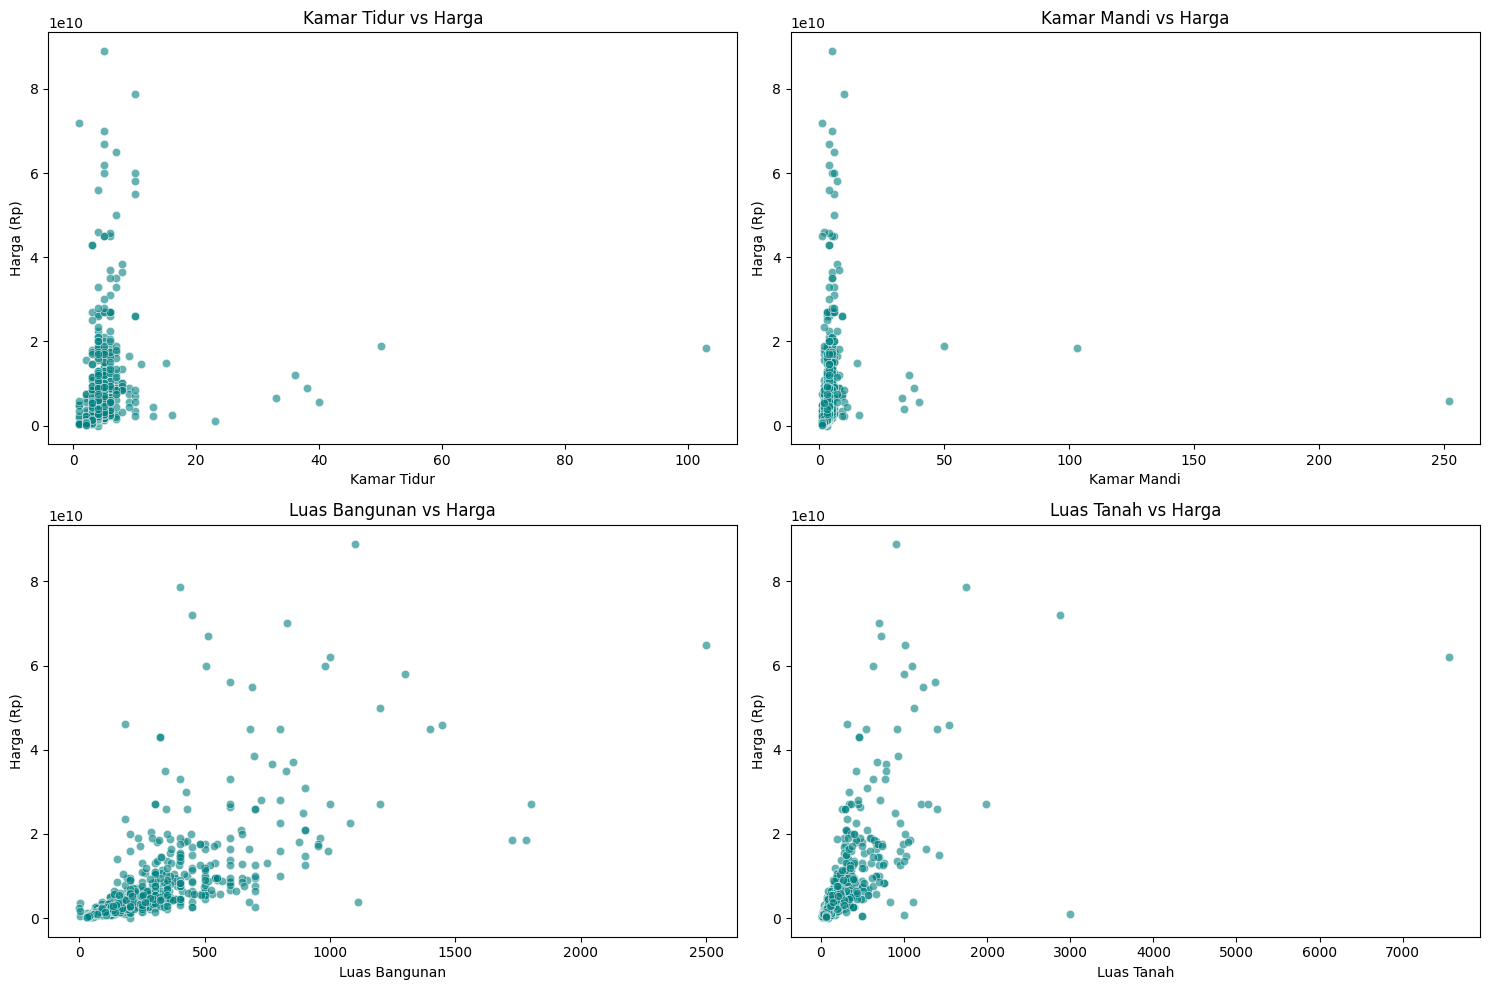

In [176]:
import matplotlib.pyplot as plt
import seaborn as sns

# Daftar fitur numerik yang ingin dibandingkan dengan Harga
fitur = ['Kamar Tidur', 'Kamar Mandi', 'Luas Bangunan', 'Luas Tanah']

# Ukuran figure
plt.figure(figsize=(15, 10))

# Buat scatter plot untuk masing-masing fitur
for i, kolom in enumerate(fitur, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=df_clean[kolom], y=df_clean['Harga'], alpha=0.6, color='teal')
    plt.title(f'{kolom} vs Harga')
    plt.xlabel(kolom)
    plt.ylabel('Harga (Rp)')

plt.tight_layout()
plt.show()


In [179]:
def remove_outliers_iqr(df, kolom):
    Q1 = df[kolom].quantile(0.25)
    Q3 = df[kolom].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[kolom] >= lower_bound) & (df[kolom] <= upper_bound)]

# Kolom-kolom yang akan diperiksa outliernya
fitur_numerik = ['Kamar Tidur', 'Kamar Mandi', 'Luas Bangunan', 'Luas Tanah', 'Harga']

# Bersihkan outlier dari semua kolom
for kolom in fitur_numerik:
    df_clean = remove_outliers_iqr(df_clean, kolom)


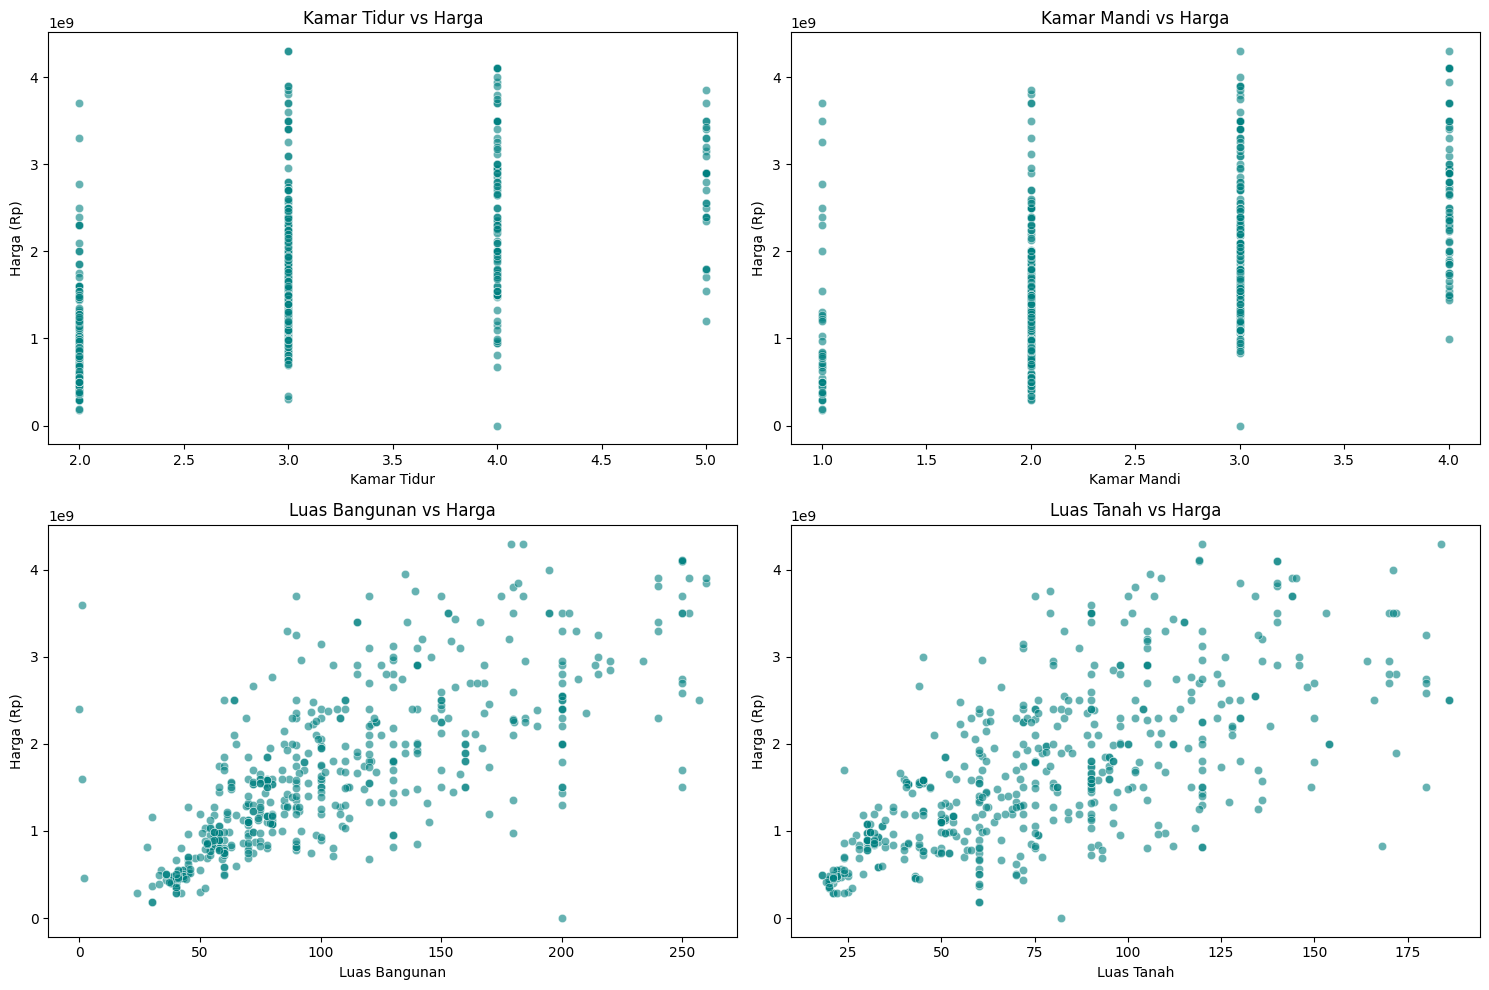

In [180]:
# Daftar fitur numerik yang ingin dibandingkan dengan Harga
fitur = ['Kamar Tidur', 'Kamar Mandi', 'Luas Bangunan', 'Luas Tanah']

# Ukuran figure
plt.figure(figsize=(15, 10))

# Buat scatter plot untuk masing-masing fitur
for i, kolom in enumerate(fitur, 1):
    plt.subplot(2, 2, i)
    sns.scatterplot(x=df_clean[kolom], y=df_clean['Harga'], alpha=0.6, color='teal')
    plt.title(f'{kolom} vs Harga')
    plt.xlabel(kolom)
    plt.ylabel('Harga (Rp)')

plt.tight_layout()
plt.show()


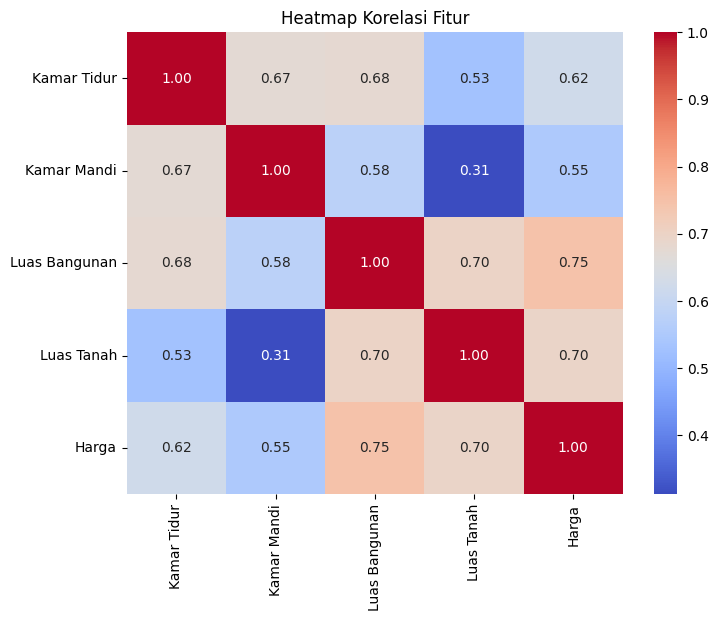

In [181]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_clean.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Heatmap Korelasi Fitur")
plt.show()


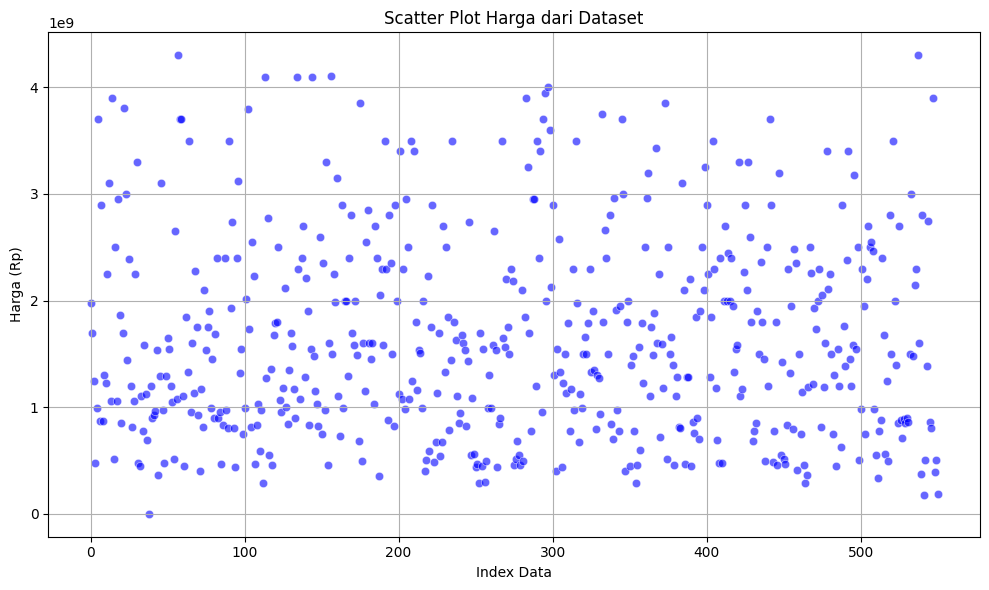

In [200]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(x=range(len(df_clean)), y=df_clean["Harga"], alpha=0.6, color='blue')
plt.xlabel("Index Data")
plt.ylabel("Harga (Rp)")
plt.title("Scatter Plot Harga dari Dataset")
plt.grid(True)
plt.tight_layout()
plt.show()


In [201]:
df_clean.to_csv('Data_Lamudi_Cleaned1.csv', index=False)